In [1]:
from langchain_community.document_loaders import PyMuPDFLoader

# 문서 로드
loader = PyMuPDFLoader('../data/KCI_FI003153549.pdf')
documents = loader.load()

In [2]:
documents

[Document(metadata={'producer': 'ezPDF Builder Supreme', 'creator': '', 'creationdate': '2024-12-27T02:09:00+09:00', 'source': '../data/KCI_FI003153549.pdf', 'file_path': '../data/KCI_FI003153549.pdf', 'total_pages': 12, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-12-27T02:09:00+09:00', 'trapped': '', 'modDate': "D:20241227020900+09'00'", 'creationDate': "D:20241227020900+09'00'", 'page': 0}, page_content='JKSCI\n한국컴퓨터정보학회논문지\nJournal of The Korea Society of Computer and Information\nVol. 29 No. 12, pp. 169-180, December 2024\nhttps://doi.org/10.9708/jksci.2024.29.12.169\nClinical Trials Utilizing LLM-Based Generative AI\n1)Hyon-Chel Jung*,  Kun-Soo Shin**,  Ho-Dong Kim***,  Sung-Bin Park****\n*Research Professor, Dept. of Institute of Artificial Intelligence and Big Data in Medicine, Yonsei University \nWonju College of Medicine, Korea \n**Researcher, Dept. of Yonsei University Future Medical Industry Cooperation Group, Korea\n***Exe

In [3]:
documents[1].metadata

{'producer': 'ezPDF Builder Supreme',
 'creator': '',
 'creationdate': '2024-12-27T02:09:00+09:00',
 'source': '../data/KCI_FI003153549.pdf',
 'file_path': '../data/KCI_FI003153549.pdf',
 'total_pages': 12,
 'format': 'PDF 1.6',
 'title': '',
 'author': '',
 'subject': '',
 'keywords': '',
 'moddate': '2024-12-27T02:09:00+09:00',
 'trapped': '',
 'modDate': "D:20241227020900+09'00'",
 'creationDate': "D:20241227020900+09'00'",
 'page': 1}

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 문서 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
splitted_documents = text_splitter.split_documents(documents)

In [5]:
len(splitted_documents)

42

In [6]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
load_dotenv()

# 임베딩 모델 준비
embedding_model = GoogleGenerativeAIEmbeddings(
    model="gemini-embedding-001",
)

In [7]:

from langchain_community.vectorstores import FAISS

# FAISS 벡터스토어 생성 및 저장
vectorstore = FAISS.from_documents(splitted_documents, embedding_model)
vectorstore.save_local("faiss_index")

In [8]:
# 벡터스토어 재로딩
vectorstore = FAISS.load_local(
    "faiss_index",
    embedding_model,
    allow_dangerous_deserialization=True,
)

In [9]:
# 리트리버 생성
retriever = vectorstore.as_retriever()

In [10]:
# 예시 질의
query = "본 연구에서 Private LLM 구축을 위해 수집한 문서의 총 페이지 수와 문서 유형별 비율은 어떻게 되나요?"

In [11]:

retriever.invoke(query)

[Document(id='809aa901-fec5-485a-8880-62ed0e723034', metadata={'producer': 'ezPDF Builder Supreme', 'creator': '', 'creationdate': '2024-12-27T02:09:00+09:00', 'source': '../data/KCI_FI003153549.pdf', 'file_path': '../data/KCI_FI003153549.pdf', 'total_pages': 12, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-12-27T02:09:00+09:00', 'trapped': '', 'modDate': "D:20241227020900+09'00'", 'creationDate': "D:20241227020900+09'00'", 'page': 4}, page_content='의료기기 임상시험 분야의 도메인 특성에 맞게 튜닝하\n기 위해 의료기기 임상시험 전문가로부터 총 158개의 문\n서(총 11,954 페이지)를 수집하였다. 수집된 문서는 다음\n과 같이 분류된다:\ny 규제 문서 (30%): FDA, EMA, PMDA 가이드라인, \nGCP 문서 등\ny 교육 자료 (20%): 임상시험 수행자 교육 매뉴얼, 온라\n인 강의 자료 등\ny 프로토콜 및 보고서 (25%): 임상시험 프로토콜, CSR \n(Clinical Study Report) 템플릿 등\ny 의료기기 특화 문서 (15%): 의료기기 임상시험 계획\n서, 기술문서 등\ny 기타 (10%): 윤리위원회 관련 문서, 환자 동의서 템플\n릿 등\n1.2 Validity of Collected Data\n수집된 \n데이터셋은 \n의료기기 \n임상시험에 \n특화된 \nPrivate LLM 구축을 위해 도메인 적합성과 다양성, 그리\n고 응용 가능성 측면에서 높은 타당성을 갖추고 있다. 

In [12]:

from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    '''다음 컨텍스트만 사용해 질문에 답하세요.
컨텍스트:{context}

질문: {question}
'''
)

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

chain = prompt | llm | StrOutputParser()

In [14]:
results = vectorstore.similarity_search(query, k=5) # 검색을 외부에서 미리 실행한 후 반환된 결과 사용

In [15]:


response = chain.invoke({'context': results, 'question': query})

In [16]:
print(response)

본 연구에서 Private LLM 구축을 위해 수집한 문서의 총 페이지 수는 **11,954 페이지**입니다.

문서 유형별 비율은 다음과 같습니다:
*   **규제 문서**: 30% (FDA, EMA, PMDA 가이드라인, GCP 문서 등)
*   **교육 자료**: 20% (임상시험 수행자 교육 매뉴얼, 온라인 강의 자료 등)
*   **프로토콜 및 보고서**: 25% (임상시험 프로토콜, CSR 템플릿 등)
*   **의료기기 특화 문서**: 15% (의료기기 임상시험 계획서, 기술문서 등)
*   **기타**: 10% (윤리위원회 관련 문서, 환자 동의서 템플릿 등)


### LangGraph RAG

In [17]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [18]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [19]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다

In [20]:
# LangChain의 hub에 정의된 검증된 RAG 프롬프트 활용
# https://smith.langchain.com/hub
# rlm: LangChain 팀이 공식적으로 유지보수하는 프롬프트를 의미
# rag-prompt: 해당 소유자가 게시한 프롬프트의 이름
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

In [21]:
print(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [22]:
def generate(state: AgentState) -> AgentState:
    """
    사용자의 질문과 검색된 문서를 기반으로 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답이 추가된 state를 반환합니다.
    """
    context = state['context']  # state에서 검색된 문서를 추출합니다.
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    rag_chain = prompt | llm  # RAG 프롬프트와 LLM을 연결하여 체인을 만듭니다.
    response = rag_chain.invoke({'question': query, 'context': context})  # 질문과 문맥을 사용하여 응답을 생성합니다.
    return {'answer': response}  # 생성된 응답을 포함한 state를 반환합니다.

In [23]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [24]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate')
graph_builder.add_edge('generate', END)

In [25]:
graph = graph_builder.compile()

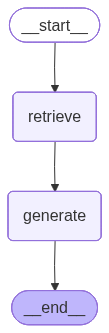

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [27]:
initial_state = {'query': query}
result = graph.invoke(initial_state)

In [28]:
result

{'query': '본 연구에서 Private LLM 구축을 위해 수집한 문서의 총 페이지 수와 문서 유형별 비율은 어떻게 되나요?',
 'context': [Document(id='809aa901-fec5-485a-8880-62ed0e723034', metadata={'producer': 'ezPDF Builder Supreme', 'creator': '', 'creationdate': '2024-12-27T02:09:00+09:00', 'source': '../data/KCI_FI003153549.pdf', 'file_path': '../data/KCI_FI003153549.pdf', 'total_pages': 12, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-12-27T02:09:00+09:00', 'trapped': '', 'modDate': "D:20241227020900+09'00'", 'creationDate': "D:20241227020900+09'00'", 'page': 4}, page_content='의료기기 임상시험 분야의 도메인 특성에 맞게 튜닝하\n기 위해 의료기기 임상시험 전문가로부터 총 158개의 문\n서(총 11,954 페이지)를 수집하였다. 수집된 문서는 다음\n과 같이 분류된다:\ny 규제 문서 (30%): FDA, EMA, PMDA 가이드라인, \nGCP 문서 등\ny 교육 자료 (20%): 임상시험 수행자 교육 매뉴얼, 온라\n인 강의 자료 등\ny 프로토콜 및 보고서 (25%): 임상시험 프로토콜, CSR \n(Clinical Study Report) 템플릿 등\ny 의료기기 특화 문서 (15%): 의료기기 임상시험 계획\n서, 기술문서 등\ny 기타 (10%): 윤리위원회 관련 문서, 환자 동의서 템플\n릿 등\n1.2 Validity of Collected Data\n수집된 \n데이터셋은 \n

In [31]:
print(result['answer'].content)

본 연구에서 Private LLM 구축을 위해 총 11,954페이지에 달하는 158개의 문서가 수집되었습니다. 수집된 문서는 규제 문서(30%), 교육 자료(20%), 프로토콜 및 보고서(25%), 의료기기 특화 문서(15%), 기타(10%)로 구성됩니다.
